# Generate Flow-Centric DCN Benchmark Traffic

In this example, we will use `TrafPy` to generate the flow-centric data centre network benchmark traffic traces (University, Private Enterprise, Commercial Cloud, and Social Media Cloud) for a custom network topology. We will then save these traffic traces as .pickle files, which can then be imported into any simulation, emulation, or experimentation environment/test bed independently of `TrafPy`. 

To do this, we will need to use the `trafpy.generator` and `trafpy.benchmarker` modules.

In [1]:
import trafpy.generator as tpg
from trafpy.benchmarker import BenchmarkImporter

## 1. Define the Network

Consider that you have a network with $n_{n}=64$ end points/machines/leaf nodes, and that you've defined your network externally to TrafPy, but you would like to use TrafPy to generate the University, Private Enterprise, Commercial Cloud, and Social Media Cloud traffic traces for your network. Regardless of your network's topology, we can use the `trafpy.generator.gen_arbitrary_network()` function to initialise an arbitrary representation of your network which TrafPy can recognise and create traffic data for.

Start by setting how many end points are in your network:

In [2]:
num_eps = 64

### (Optional) End Point Clusters/Racks
In the context of data centre networks, it is common to cluster end points/machines into *racks*. This can lead to varying levels of end point and end point pair traffic loads (e.g. inter vs. intra-rack traffic load). `TrafPy` lets you group your end points into racks by providing a `racks_dict` dictionary which maps racks (keys) to the list of end points (values) within each rack. If your network did not have any clustering/racks, you could simply set `racks_dict=None`, but consider that your $n_{n}=64$ network has 8 servers per rack (8 racks overall).

In [3]:
racks_dict, num_racks = {}, 8
eps_per_rack = int(num_eps/num_racks)
for rack in range(num_racks):
    racks_dict[rack] = [ep for ep in range(rack*eps_per_rack, (rack*eps_per_rack)+eps_per_rack)]
print(racks_dict)

{0: [0, 1, 2, 3, 4, 5, 6, 7], 1: [8, 9, 10, 11, 12, 13, 14, 15], 2: [16, 17, 18, 19, 20, 21, 22, 23], 3: [24, 25, 26, 27, 28, 29, 30, 31], 4: [32, 33, 34, 35, 36, 37, 38, 39], 5: [40, 41, 42, 43, 44, 45, 46, 47], 6: [48, 49, 50, 51, 52, 53, 54, 55], 7: [56, 57, 58, 59, 60, 61, 62, 63]}


### Network Bandwidth Capacity

Each link in your network will have (1) some bandwidth capacity per link channel (the maximum rate of information transfer per unit time on each channel) $C_{c}$, and (2) some number of channels per link $n_{c}$. `TrafPy` will assume that your links are *bidirectional*, meaning traffic can simultaneously be outbound and inbound from/to a given end point, therefore each link channel's bandwidth is split between the end points' transceiver (source) and receiver (destination) port. Consider that your network has link channel capacity $C_{c}=1250$ and $n_{c}=1$ channels:

In [4]:
ep_capacity = 1250

You can now initialise your network in a format recognised by `TrafPy` using the `trafpy.generator.gen_arbitrary_network()` function:

In [5]:
net = tpg.gen_arbitrary_network(num_eps=num_eps, ep_capacity=ep_capacity, racks_dict=racks_dict)

The *total network capacity* $C_{t}$ is the maximum amount of information which can be transmitted through the entire network per unit time. If 2 end points are connected, the most amount of information they can transfer along a single channel per unit time is the end point bandwidth capacity per channel $C_{c}$ (*not* $2 \cdot C_{c}$), therefore the network's total capacity $C_{t}$ can be evaluated as:

\begin{equation}
    C_{t} = \frac{n_{n} \cdot C_{c} \cdot n_{c}}{2}
\end{equation}

All `TrafPy` networks and graphs are `NetworkX` graphs (see [here](https://networkx.org/documentation/stable/tutorial.html) for details) which can be treated as Python dictionaries. All `TrafPy` networks have the following 'global' graph keys:

In [6]:
print(net.graph.keys())
print(net.graph['topology_type'])

dict_keys(['endpoints', 'endpoint_label', 'num_channels_per_link', 'ep_link_capacity', 'ep_link_port_capacity', 'max_nw_capacity', 'curr_nw_capacity_used', 'num_active_connections', 'total_connections_blocked', 'node_labels', 'topology_type', 'channel_names', 'rack_to_ep_dict', 'ep_to_rack_dict'])
arbitrary_endpoints_64_chancap_1250_channels_1


Notice that TrafPy has automatically evaluated the maximum capacity of your network:

In [7]:
print(net.graph['max_nw_capacity'])
print(net.graph['topology_type'])

40000.0
arbitrary_endpoints_64_chancap_1250_channels_1


Notice also that all references to capacity have been unitless. $C_{c}=1250$ could refer to e.g. 1250 B/s, 1250 $\mu$B/ms, 1250 Gbps, and so on. This is intentional, and allows you to plug in whatever values you find convenient. Just ensure the information and time units you use are consistent.

## 2. Define the Load Configuration

The network load refers to the overall amount of traffic received by the network. This is commonly referred to as a load rate (information units arriving per unit time) or as a load fraction (the fraction of the total network capacity being requested for a given duration). `TrafPy` typically uses the load fraction definition for load, therefore loads can be varied between 0 and 1.

A key feature of `TrafPy` is that you can generate any load for your custom network. To do this, you should provide `TrafPy` with a `network_load_config` dictionary which tells `TrafPy` (1) the end point capacity of your network, (2) the maximum capacity of your network, and (3) the overall load fraction you would like `TrafPy` to generate for your network. Consider that you would like `TrafPy` to generate a 0.1 load traffic trace for your network (i.e. around 10% of your total network capacity will be requested per unit time):

In [8]:
network_load_config = {'network_rate_capacity': net.graph['max_nw_capacity'], 
                       'ep_link_capacity': net.graph['ep_link_capacity'],
                       'target_load_fraction': 0.1}

## 3. Load the TrafPy Benchmarks

The `trafpy.benchmarker.BenchmarkImporter` can be used to load pre-defined `TrafPy` benchmarks which are compatible with the end points we previously defined for our custom network.

`TrafPy` is able to generate arbitrary distributions and therefore arbitrary traffic traces. As the nature of applications handled by real data centres changes, so too will the resultant traffic traces. Therefore, the initial benchmarks established for `TrafPy` have been stored under `benchmark_version='0.0.1'` with the anticipation that future benchmark versions will be established with new and evolving traffic traces.

In [9]:
importer = BenchmarkImporter(benchmark_version='0.0.1', load_prev_dists=False)

load_prev_dist=False. Will re-generate dists with given network params and override any previously saved distributions.


We can now import the University, Private Enterprise, Commercial Cloud, and Social Media Cloud `TrafPy` benchmark distributions adapted for our network's endpoints:

In [35]:
dcn_dists = {}
for dcn in ['university', 'private_enterprise', 'commercial_cloud', 'social_media_cloud']:
    dcn_dists[dcn] = importer.get_benchmark_dists(benchmark=dcn, eps=net.graph['endpoints'])

Generating node_dist distribution for university benchmark...
Generating flow_size_dist distribution for university benchmark...
Generating interarrival_time_dist distribution for university benchmark...
Generating node_dist distribution for private_enterprise benchmark...
Generating flow_size_dist distribution for private_enterprise benchmark...
Generating interarrival_time_dist distribution for private_enterprise benchmark...
Generating node_dist distribution for commercial_cloud benchmark...
Generating flow_size_dist distribution for commercial_cloud benchmark...
Generating interarrival_time_dist distribution for commercial_cloud benchmark...
Generating node_dist distribution for social_media_cloud benchmark...
Generating flow_size_dist distribution for social_media_cloud benchmark...
Generating interarrival_time_dist distribution for social_media_cloud benchmark...


Each benchmark contains the following distributions (stored as dictionaries with key (distribution name) value (distribution hash table) pairs):

In [11]:
print(list(dcn_dists['university'].keys()))

['node_dist', 'flow_size_dist', 'interarrival_time_dist', 'num_ops_dist']


For flow-centric traffic, we only need to worry about flow size, inter-arrival time, and node distributions.

## 4. (Optional) Define Additional Trace Parameters

`TrafPy` generates traffic trace data for your network using the `trafpy.generator.create_demand_data()` function. This function has some useful additional parameters you can define to further customise the trace generated for your network (see documentation for details).

An important parameter in `TrafPy` traffic generation is the `jensen_shannon_distance_threshold`. Since `TrafPy` traffic data are generated by sampling from some pre-defined distributions, how similar the sampled data are to the original distributions will depend on the number of demands generated/sampled by the law of large numbers. `TrafPy` lets you set the `jensen_shannon_distance_threshold`, which must be between 0 and 1. A lower value will result in more demands being generated and therefore a data set more similar to the original distributions (in the example, benchmarks) you are sampling from, whereas a higher value will be less reliably similar but will result in fewer demands (which can reduce the memory and time size of your tests).

Other useful additional parameters include `min_last_demand_arrival_time`, `min_num_demands`, and `max_num_demands`. See documentation for details.

Here, we will set `jensen_shannon_distance_threshold=0.9` (a high value so that we don't generate many demands and therefore save time).

In [12]:
jsd_threshold = 0.9

## 5. Generate the Traffic Traces

With our network defined and our benchmark distributions loaded, we are now ready to generate some traffic for our custom network using the `trafpy.generator.create_demand_data()` function. We will save our traffic into separate .pickle files. These files can then be imported into your own simulation, emulation, and/or experimentation test beds to test your own systems under these `TrafPy` benchmarks.

In [13]:
from pathlib import Path
import gzip
import pickle
import time

path_to_data = 'data/generate_flow_benchmark_traffic/'
Path(path_to_data).mkdir(exist_ok=True, parents=True)
for dcn in dcn_dists.keys():
    print('Generating \'{}\' traffic demands for {} network'.format(dcn, net.graph['topology_type']))
    time.sleep(1)
    
    # get node, flow size, and flow inter-arrival time benchmark dists
    dists = dcn_dists[dcn]
    
    # generate traffic demands
    demand_data = tpg.create_demand_data(eps=net.graph['endpoints'],
                                         node_dist=dists['node_dist'],
                                         flow_size_dist=dists['flow_size_dist'],
                                         interarrival_time_dist=dists['interarrival_time_dist'],
                                         network_load_config=network_load_config,
                                         jensen_shannon_distance_threshold=jsd_threshold)
    
    # save demands as pickle file
    filename = path_to_data+'{}_demand_data.pickle'.format(dcn)
    with gzip.open(filename, 'wb') as f:
        pickle.dump(demand_data, f)

Generating 'university' traffic demands for arbitrary_endpoints_64_chancap_1250_channels_1 network


Packed 6000 flows in 18.257545709609985 s.
Generating 'private_enterprise' traffic demands for arbitrary_endpoints_64_chancap_1250_channels_1 network


Packed 6000 flows in 19.140040636062622 s.
Generating 'commercial_cloud' traffic demands for arbitrary_endpoints_64_chancap_1250_channels_1 network


Packed 6000 flows in 18.646042585372925 s.
Generating 'social_media_cloud' traffic demands for arbitrary_endpoints_64_chancap_1250_channels_1 network


Packed 6000 flows in 26.00689458847046 s.


`demand_data` is a dictionary storing the following information for each flow (where the values are a list of values corresponding to the values assigned to each flow):

In [40]:
print(demand_data.keys())

dict_keys(['flow_id', 'sn', 'dn', 'flow_size', 'event_time', 'establish', 'index'])


## 6. Analyse the Generated Traffic

At this point, you could do your own analysis of the traffic you've generated by loading the saved data into your own scripts. However, `TrafPy` provides some useful tools for this.

We can encode our saved `demand_data` files as `trafpy.generator.Demand()` objects, and then use the `trafpy.generator.DemandsAnalyser` and `trafpy.generator.DemandPlotter` objects to analyse them:

In [27]:
from trafpy.generator import Demand, DemandsAnalyser, DemandPlotter

First collect the demand objects from each demand_data file:

In [30]:
# collect demand objects
demands = {}
for dcn in dcn_dists.keys():
    with gzip.open(path_to_data+'{}_demand_data.pickle'.format(dcn), 'rb') as f:
        demand_data = pickle.load(f)
    demands[dcn] = Demand(demand_data, net.graph['endpoints'], name=dcn)

Then use `trafpy.generator.DemandsAnalyser()` to print a summary table of all the demand data sets you generated:

In [31]:
# print summary table
analyser = DemandsAnalyser(*list(demands.values()), jobcentric=False)
analyser.compute_metrics(print_summary=True)

,Name,Flows,1st,Last,Duration,Info,Load,Smallest,Largest
0,commercial_cloud,6000,0.0,29722.91700,29722.91700,118891668.0,4000.0,1.0,8409825.0
1,private_enterprise,6000,0.0,30735.42975,30735.42975,122941719.0,4000.0,1.0,9019800.0
2,university,6000,0.0,34479.85950,34479.85950,137919438.0,4000.0,1.0,9737850.0
3,social_media_cloud,6000,0.0,63648.83400,63648.83400,254595336.0,4000.0,1.0,1616425.0


Finally, visualise your data:

university
Characteristics of Flow Size distribution: DescribeResult(nobs=6000, minmax=(1.0, 9737850.0), mean=22986.573, variance=38372921640.562096, skewness=31.91043631011033, kurtosis=1362.8987594229686)


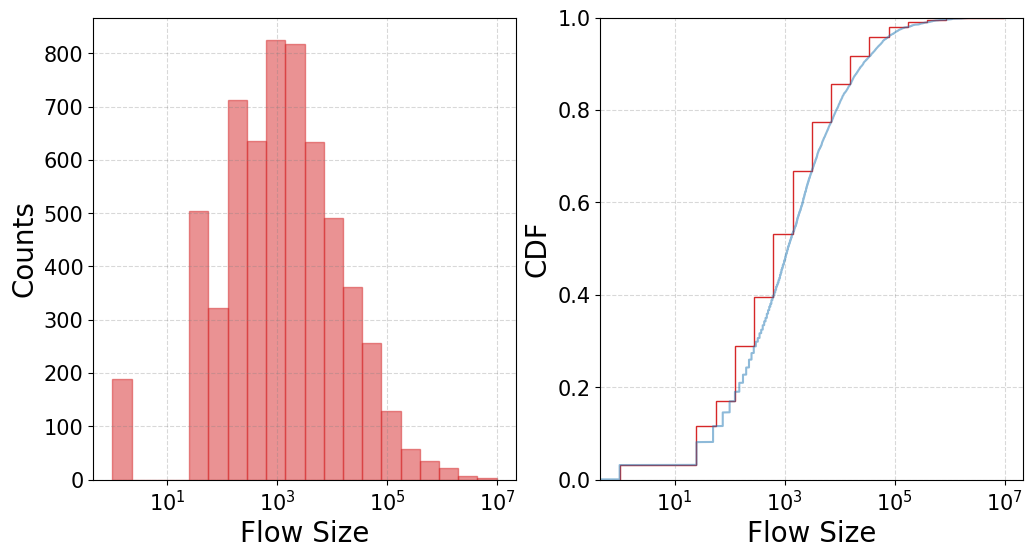

Characteristics of Interarrival Time distribution: DescribeResult(nobs=5999, minmax=(0.0009077435151993996, 56.007774906229315), mean=5.747601183530592, variance=39.44133592822895, skewness=2.2732557227636305, kurtosis=7.55057369720838)


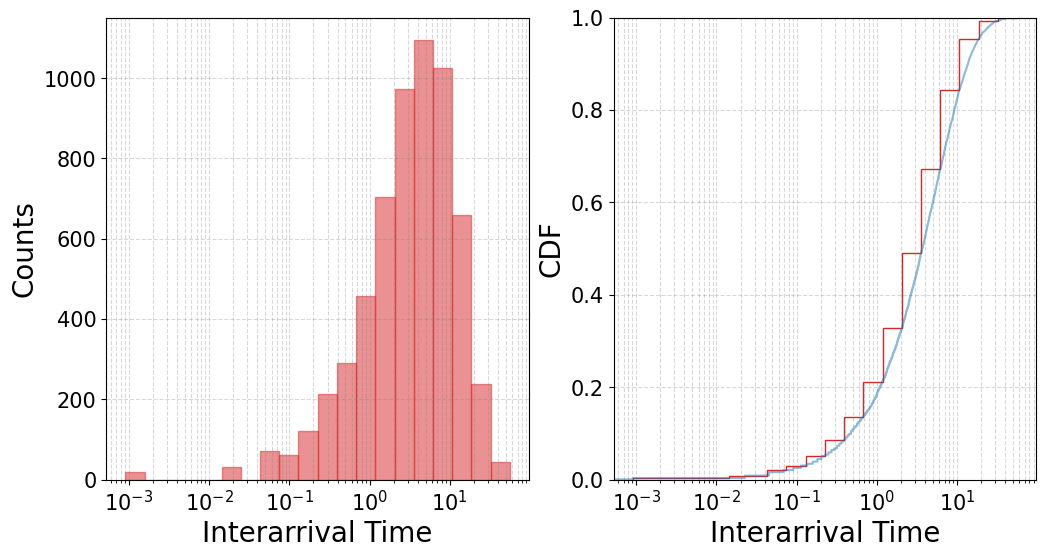

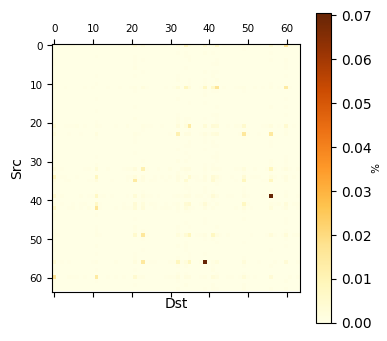

<Figure size 640x480 with 0 Axes>

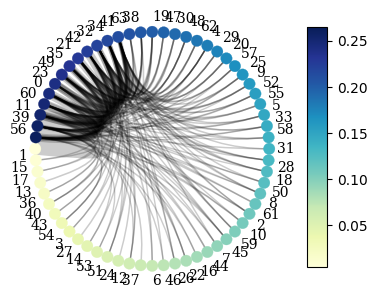

<Figure size 640x480 with 0 Axes>

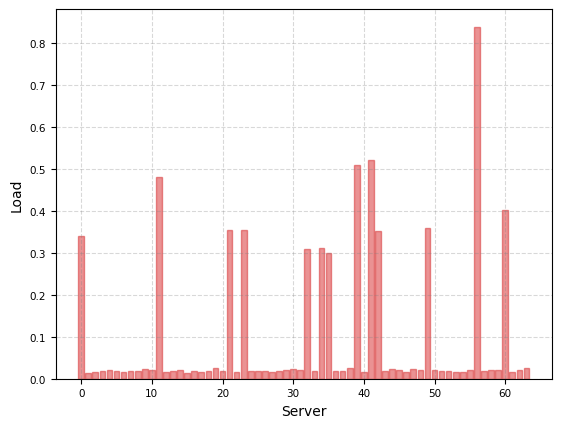

<Figure size 640x480 with 0 Axes>

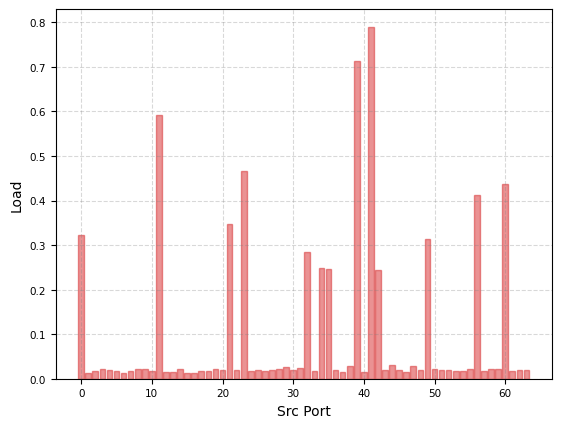

<Figure size 640x480 with 0 Axes>

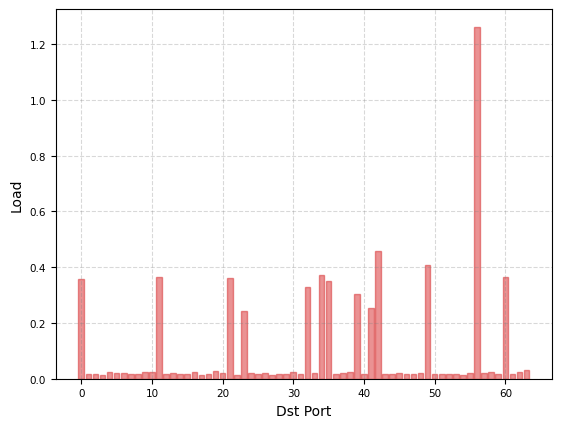

private_enterprise
Characteristics of Flow Size distribution: DescribeResult(nobs=6000, minmax=(1.0, 9019800.0), mean=20490.2865, variance=27388173314.420162, skewness=34.932830582176045, kurtosis=1649.004344231158)


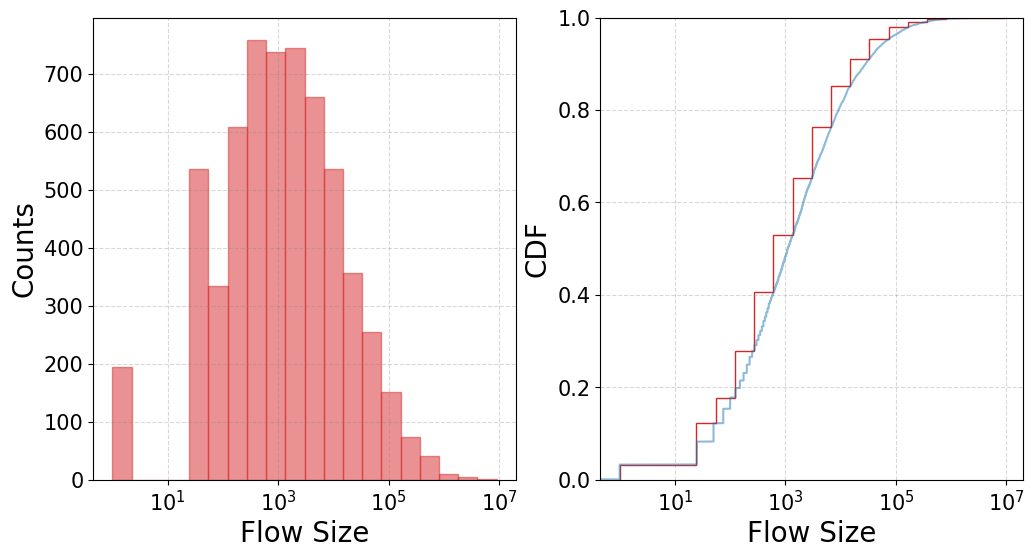

Characteristics of Interarrival Time distribution: DescribeResult(nobs=5999, minmax=(0.0017736366498866118, 177.04710637460994), mean=5.123425529254913, variance=469.7609942194861, skewness=5.436753935985985, kurtosis=30.15177514164089)


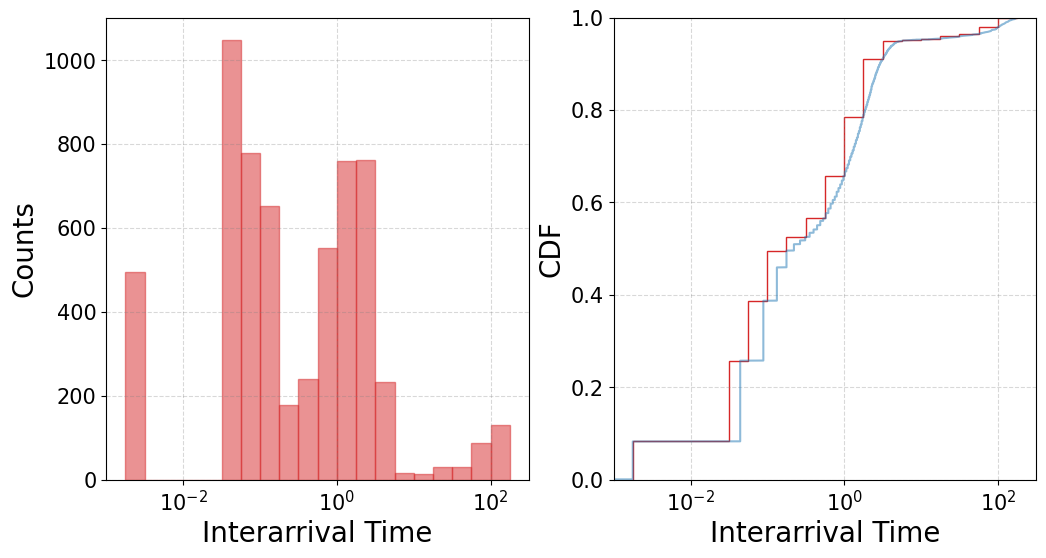

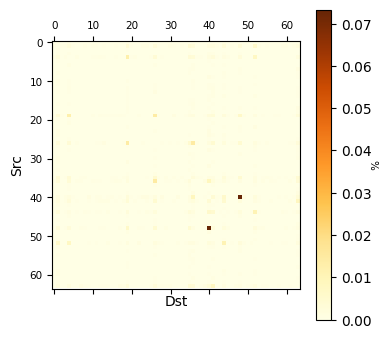

<Figure size 640x480 with 0 Axes>

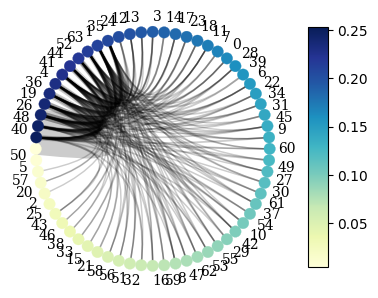

<Figure size 640x480 with 0 Axes>

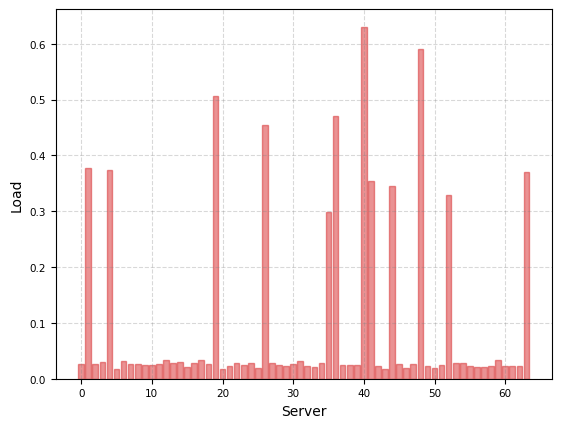

<Figure size 640x480 with 0 Axes>

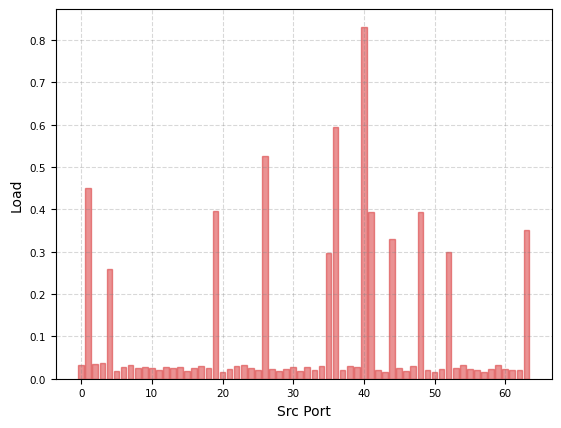

<Figure size 640x480 with 0 Axes>

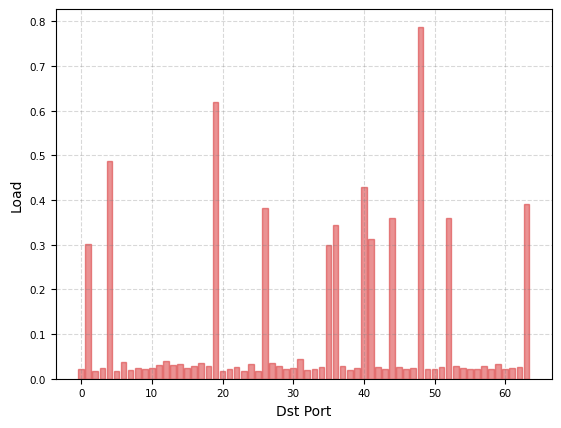

commercial_cloud
Characteristics of Flow Size distribution: DescribeResult(nobs=6000, minmax=(1.0, 8409825.0), mean=19815.278, variance=24926239918.222088, skewness=34.58224776939368, kurtosis=1576.2013022412013)


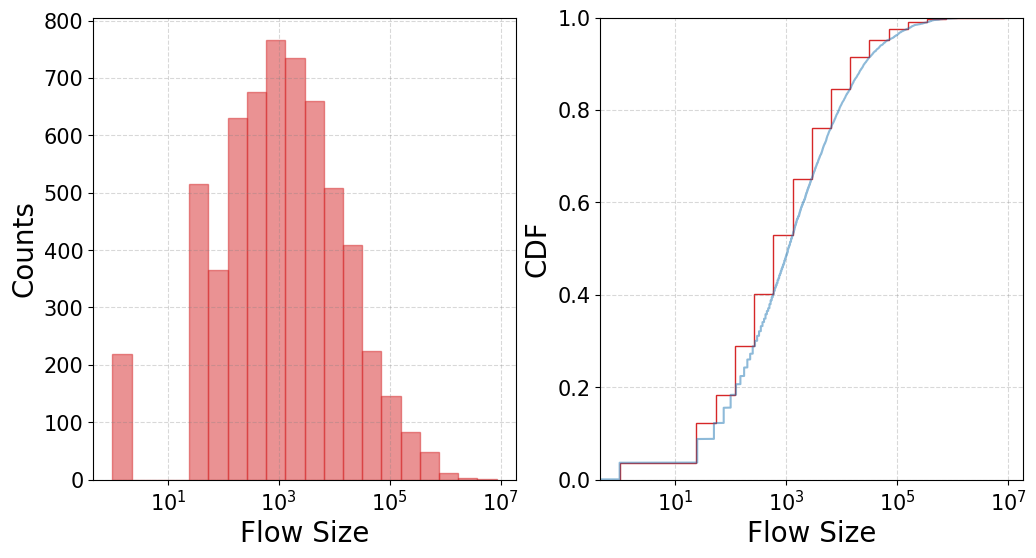

Characteristics of Interarrival Time distribution: DescribeResult(nobs=5999, minmax=(0.06567419825569232, 643.009760938583), mean=4.954645274212819, variance=1155.191186951152, skewness=14.515429509418372, kurtosis=225.98412449765644)


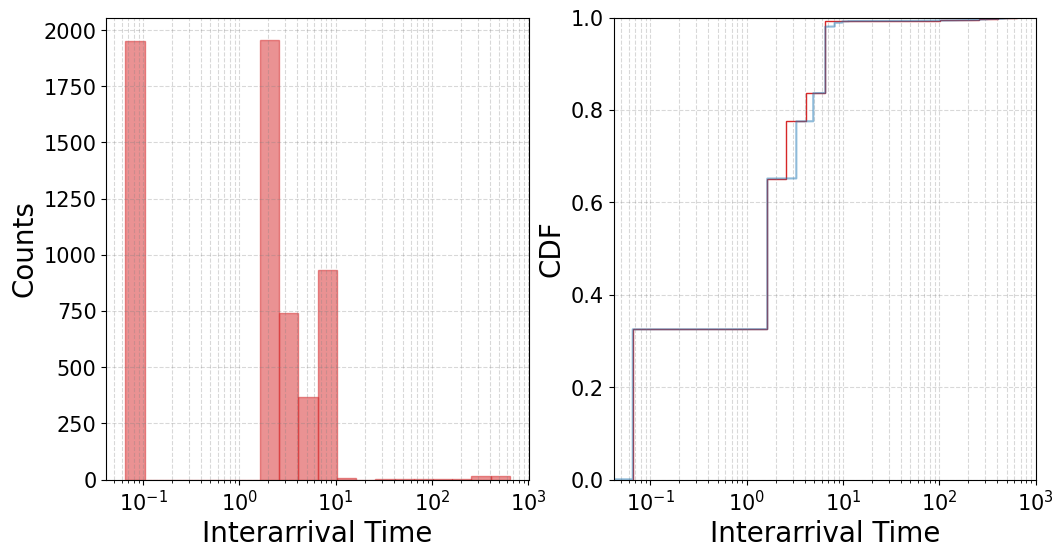

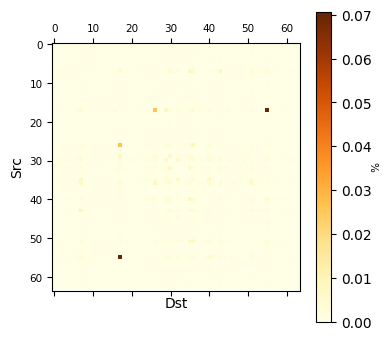

<Figure size 640x480 with 0 Axes>

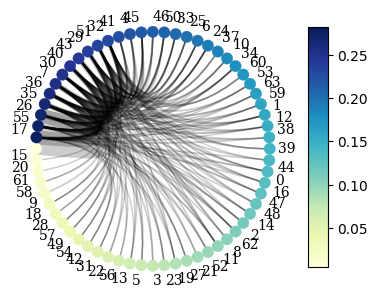

<Figure size 640x480 with 0 Axes>

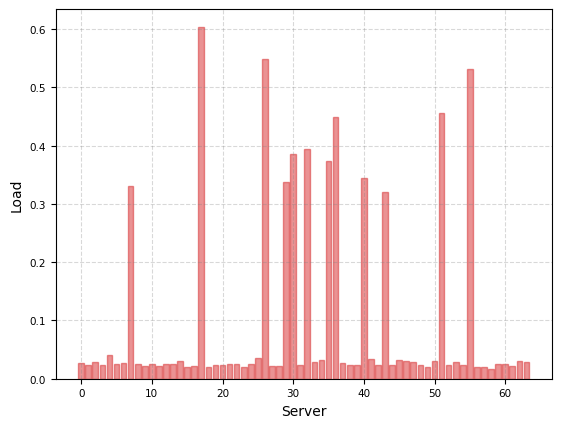

<Figure size 640x480 with 0 Axes>

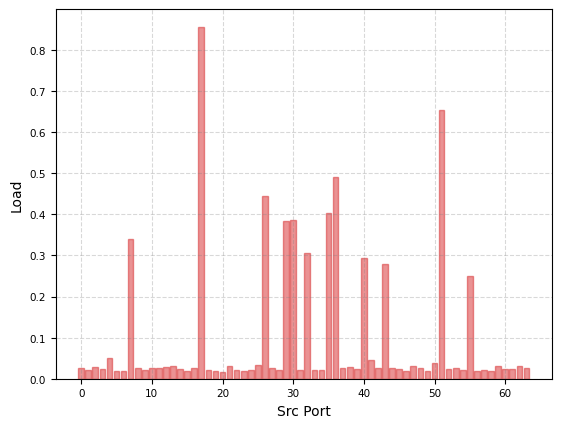

<Figure size 640x480 with 0 Axes>

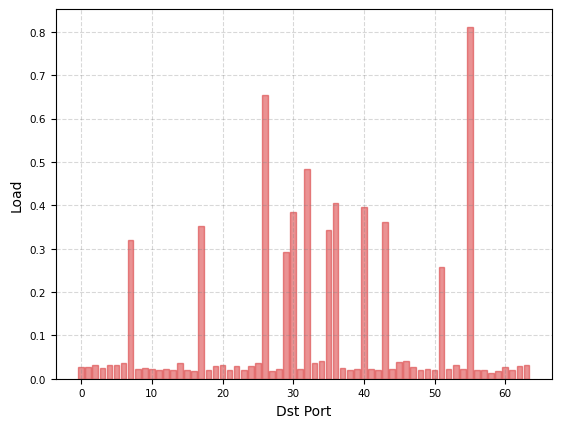

social_media_cloud
Characteristics of Flow Size distribution: DescribeResult(nobs=6000, minmax=(1.0, 1616425.0), mean=42432.556, variance=8861935623.200064, skewness=5.844517294715551, kurtosis=53.13520452967572)


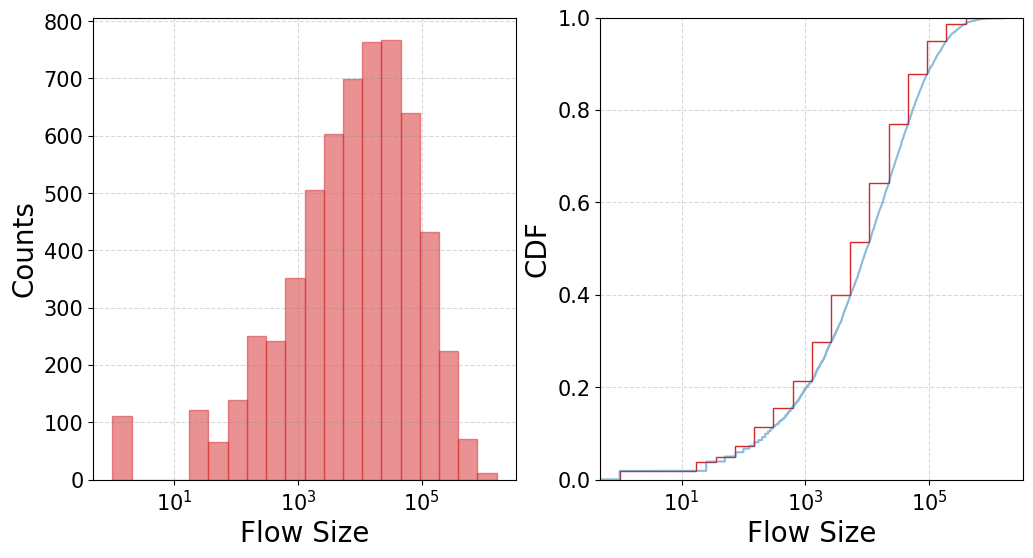

Characteristics of Interarrival Time distribution: DescribeResult(nobs=5999, minmax=(0.0017369786291965283, 4006.9491528574144), mean=10.609907317886107, variance=7090.029244476938, skewness=28.159760722993823, kurtosis=1072.1269349419458)


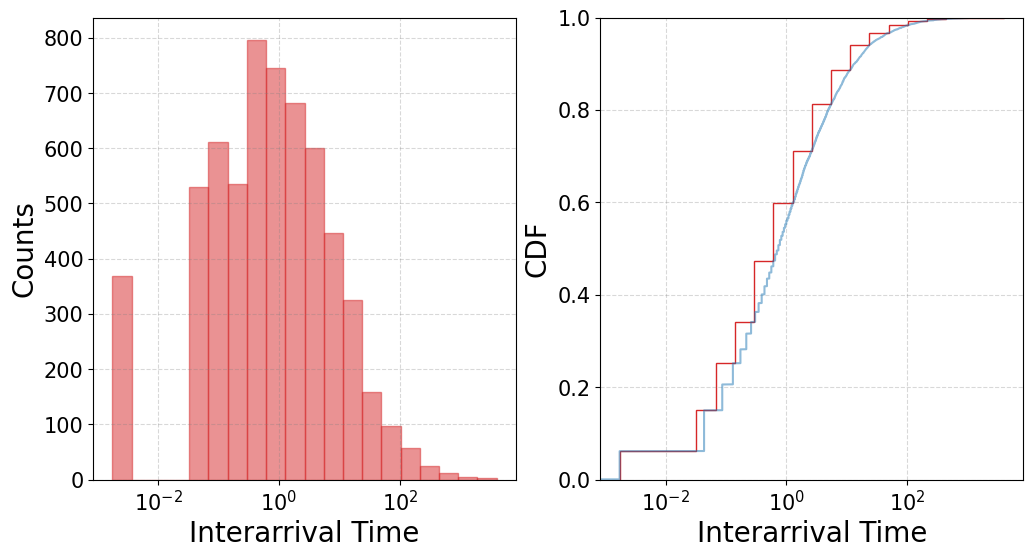

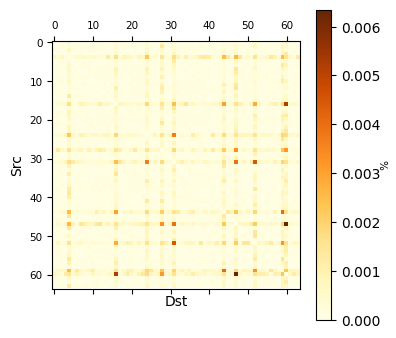

<Figure size 640x480 with 0 Axes>

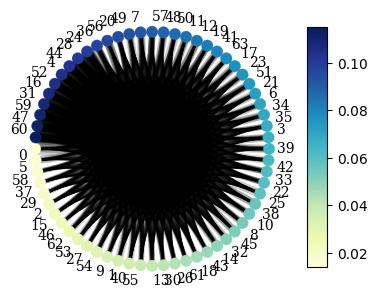

<Figure size 640x480 with 0 Axes>

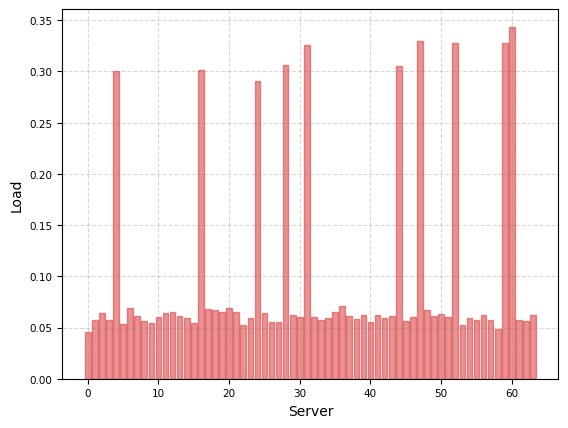

<Figure size 640x480 with 0 Axes>

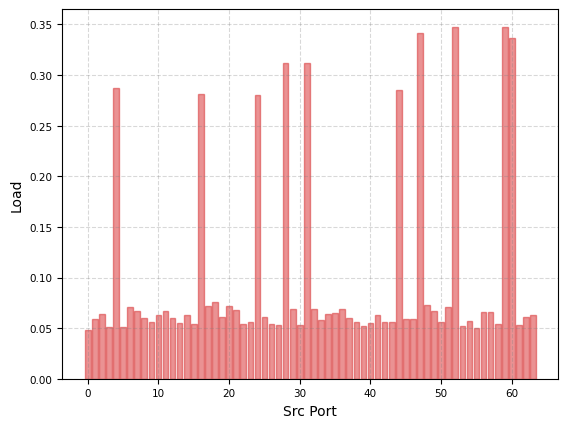

<Figure size 640x480 with 0 Axes>

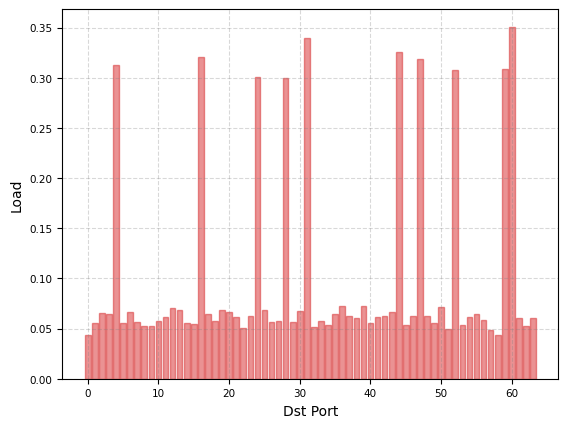

In [39]:
# visualise distributions
for dcn, demand in demands.items():
    print(dcn)
    plotter = DemandPlotter(demand)
    plotter.plot_flow_size_dist(logscale=True, figsize=(12,6))
    plotter.plot_interarrival_time_dist(logscale=True, figsize=(12,6))
    plotter.plot_node_dist(eps=net.graph['endpoints'],
                           chord_edge_width_range=[1,25],
                           chord_edge_display_threshold=0.005)
    plotter.plot_node_load_dists(eps=net.graph['endpoints'], 
                                 ep_link_bandwidth=net.graph['ep_link_capacity'],
                                 plot_extras=False)